In [1]:
# Import libraries

import pandas as pd 
import numpy as np 
import seaborn as sns 
from preprolib import myfunctions
import matplotlib.pyplot as plt 
        
print("Libraries imported....")

Libraries imported....


In [2]:
# Importing the data
df = pd.read_csv(r'C:\Users\User\Desktop\Projects\Green Crop Yield\data\Train.csv')
test = pd.read_csv(r'C:\Users\User\Desktop\Projects\Green Crop Yield\data\Test.csv')
data_desc = pd.read_csv(r'C:\Users\User\Desktop\Projects\Green Crop Yield\data\VariableDescription.csv')

In [3]:
dates = ['CropTillageDate', 'RcNursEstDate','SeedingSowingTransplanting' ,'Harv_date', 'Threshing_date']
df[dates] = df[dates].apply(pd.to_datetime)

df[dates] = df[dates].apply(lambda x: x.dt.to_period('M'))

# Convert the date columns to month names
df[dates] = df[dates].apply(lambda x: x.dt.strftime('%B'))


In [4]:
test[dates] = test[dates].apply(pd.to_datetime)

test[dates] = test[dates].apply(lambda x: x.dt.to_period('M'))

# Convert the date columns to month names
test[dates] = test[dates].apply(lambda x: x.dt.strftime('%B'))

In [5]:
# Example: Data Preprocessing
cat_cols = []
num_cols = []
ignore_list = ['ID','CropTillageDate', 'RcNursEstDate','Yield','SeedingSowingTransplanting','Harv_date','Threshing_date']

myfunctions.cat_or_num(df, ignore_list, num_cols, cat_cols)

In [6]:
import pandas as pd

# Assuming you have a DataFrame named 'df'
# 'cat_cols' is a list of categorical column names

# Create a list to store column names that meet the criteria
filtered_cat_cols = []

# Iterate through the categorical columns
for col in cat_cols:
    unique_values = df[col].nunique()  # Count the unique values in the column
    if unique_values <= 4:  # Check if there are 5 or fewer unique values
        filtered_cat_cols.append(col)

# Create a new DataFrame with the selected columns
filtered_cat_cols


['District',
 'CropEstMethod',
 'TransplantingIrrigationPowerSource',
 'PCropSolidOrgFertAppMethod',
 'MineralFertAppMethod',
 'MineralFertAppMethod.1',
 'Harv_method',
 'Threshing_method',
 'Stubble_use']

In [7]:
label = 'Yield'
features = num_cols + filtered_cat_cols

In [8]:
features

['CultLand',
 'CropCultLand',
 'CropTillageDepth',
 'SeedlingsPerPit',
 'TransplantingIrrigationHours',
 'TransIrriCost',
 'StandingWater',
 'Ganaura',
 'CropOrgFYM',
 'NoFertilizerAppln',
 'BasalDAP',
 'BasalUrea',
 '1tdUrea',
 '1appDaysUrea',
 '2tdUrea',
 '2appDaysUrea',
 'Harv_hand_rent',
 'Residue_length',
 'Residue_perc',
 'Acre',
 'District',
 'CropEstMethod',
 'TransplantingIrrigationPowerSource',
 'PCropSolidOrgFertAppMethod',
 'MineralFertAppMethod',
 'MineralFertAppMethod.1',
 'Harv_method',
 'Threshing_method',
 'Stubble_use']

### Analysis

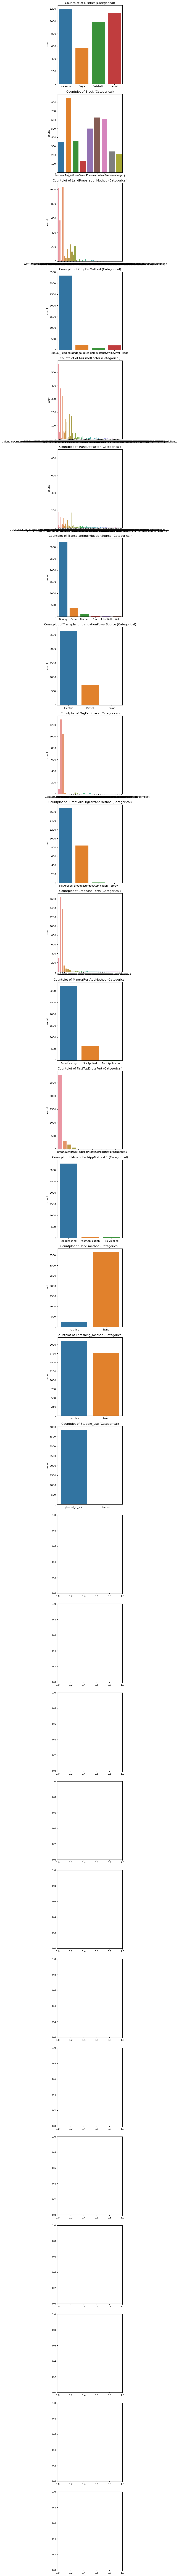

In [9]:
num_plots = len(features)
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5*num_plots))

# Loop through the features list and plot histograms
for i, col in enumerate(cat_cols):
    ax = axes[i]
    if col in num_cols:
        # If it's a numerical column, plot a histogram
        sns.histplot(data=df, x=col, ax=ax, kde=True)
        ax.set_title(f'Histogram of {col} (Numerical)')
    else:
        # If it's a categorical column, plot a countplot
        sns.countplot(data=df, x=col, ax=ax)
        ax.set_title(f'Countplot of {col} (Categorical)')
    ax.set_xlabel('')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [10]:
sep_cols = ['CropbasalFerts', 'OrgFertilizers', 'TransDetFactor', 'NursDetFactor', 'LandPreparationMethod']

In [11]:
sep_cols

['CropbasalFerts',
 'OrgFertilizers',
 'TransDetFactor',
 'NursDetFactor',
 'LandPreparationMethod']

In [12]:
import pandas as pd

# Assuming you have your DataFrame named 'data'
# Initialize a list to store columns with more than 1000 null values
columns_with_more_than_1000_nulls = []

for column in df[num_cols].columns:
    null_count = df[column].isnull().sum()
    if null_count > 1000:
        columns_with_more_than_1000_nulls.append(column)    

columns_with_more_than_1000_nulls

['Ganaura', 'CropOrgFYM', 'BasalUrea', '2tdUrea', '2appDaysUrea']

In [13]:
df.loc[:,sep_cols]

,CropbasalFerts,OrgFertilizers,TransDetFactor,NursDetFactor,LandPreparationMethod
0,Urea,NaN,CalendarDate SeedlingAge RainArrival IrrigWate...,CalendarDate IrrigWaterAvailability SeedAvaila...,TractorPlough FourWheelTracRotavator
1,DAP Urea,NaN,CalendarDate SeedlingAge RainArrival IrrigWate...,CalendarDate PreMonsoonShowers IrrigWaterAvail...,WetTillagePuddling TractorPlough FourWheelTrac...
2,DAP,Ganaura FYM,SeedlingAge IrrigWaterAvailability LaborAvaila...,PreMonsoonShowers IrrigWaterAvailability Labou...,TractorPlough FourWheelTracRotavator
3,DAP Urea,Ganaura,CalendarDate SeedlingAge RainArrival IrrigWate...,CalendarDate PreMonsoonShowers IrrigWaterAvail...,TractorPlough FourWheelTracRotavator
4,Urea DAP,NaN,SeedlingAge RainArrival IrrigWaterAvailability...,CalendarDate IrrigWaterAvailability SeedAvaila...,TractorPlough WetTillagePuddling
...,...,...,...,...,...
3865,DAP Urea,Ganaura,NaN,NaN,WetTillagePuddling TractorPlough FourWheelTrac...
3866,DAP,NaN,IrrigWaterAvailability LaborAvailability,IrrigWaterAvailability LabourAvailability,WetTillagePuddling TractorPlough FourWheelTrac...
3867,Urea,Ganaura,CalendarDate IrrigWaterAvailability,CalendarDate IrrigWaterAvailability,TractorPlough
3868,DAP Urea,NaN,IrrigWaterAvailability RainArrival SeedlingAge,SeedAvailability IrrigWaterAvailability,TractorPlough


In [14]:
def onehot_seperator(df, columns):
    unique_words = set()  # Initialize an empty set to store unique words
    
    for column in columns:
        # Split the column values into words
        df[column] = df[column].astype(str)
        words = df[column].str.split()

        # Create a set of unique words for this column, excluding NaN
        unique_words.update(word for word_list in words if word_list is not None for word in word_list)

    return unique_words

unique_words = onehot_seperator(df, sep_cols)

In [15]:
import pandas as pd

def onehot_seperator(df, columns, test=None):
    for column in columns:
        # Check if the column contains non-null string values
        if df[column].dtype == 'object':
            # Split the column values into words
            df[column] = df[column].astype(str)
            words = df[column].str.split()

            # Create a set of unique words
            unique_words = set(word for word_list in words for word in word_list)

            # Create binary columns for each unique word in the original dataframe
            for word in unique_words:
                df[word] = df[column].apply(lambda x: word in x)
                df[word] = df[word].replace({True: 1, False: 0})

            # If a test dataframe is provided, create the same columns in the test dataframe
            if test is not None:
                for word in unique_words:
                    if test[column].dtype == 'object':
                        test[column] = test[column].astype(str)
                        test[word] = test[column].apply(lambda x: word in x)
                        test[word] = test[word].astype(int)

    return df, test

df, test = onehot_seperator(df, sep_cols, test)


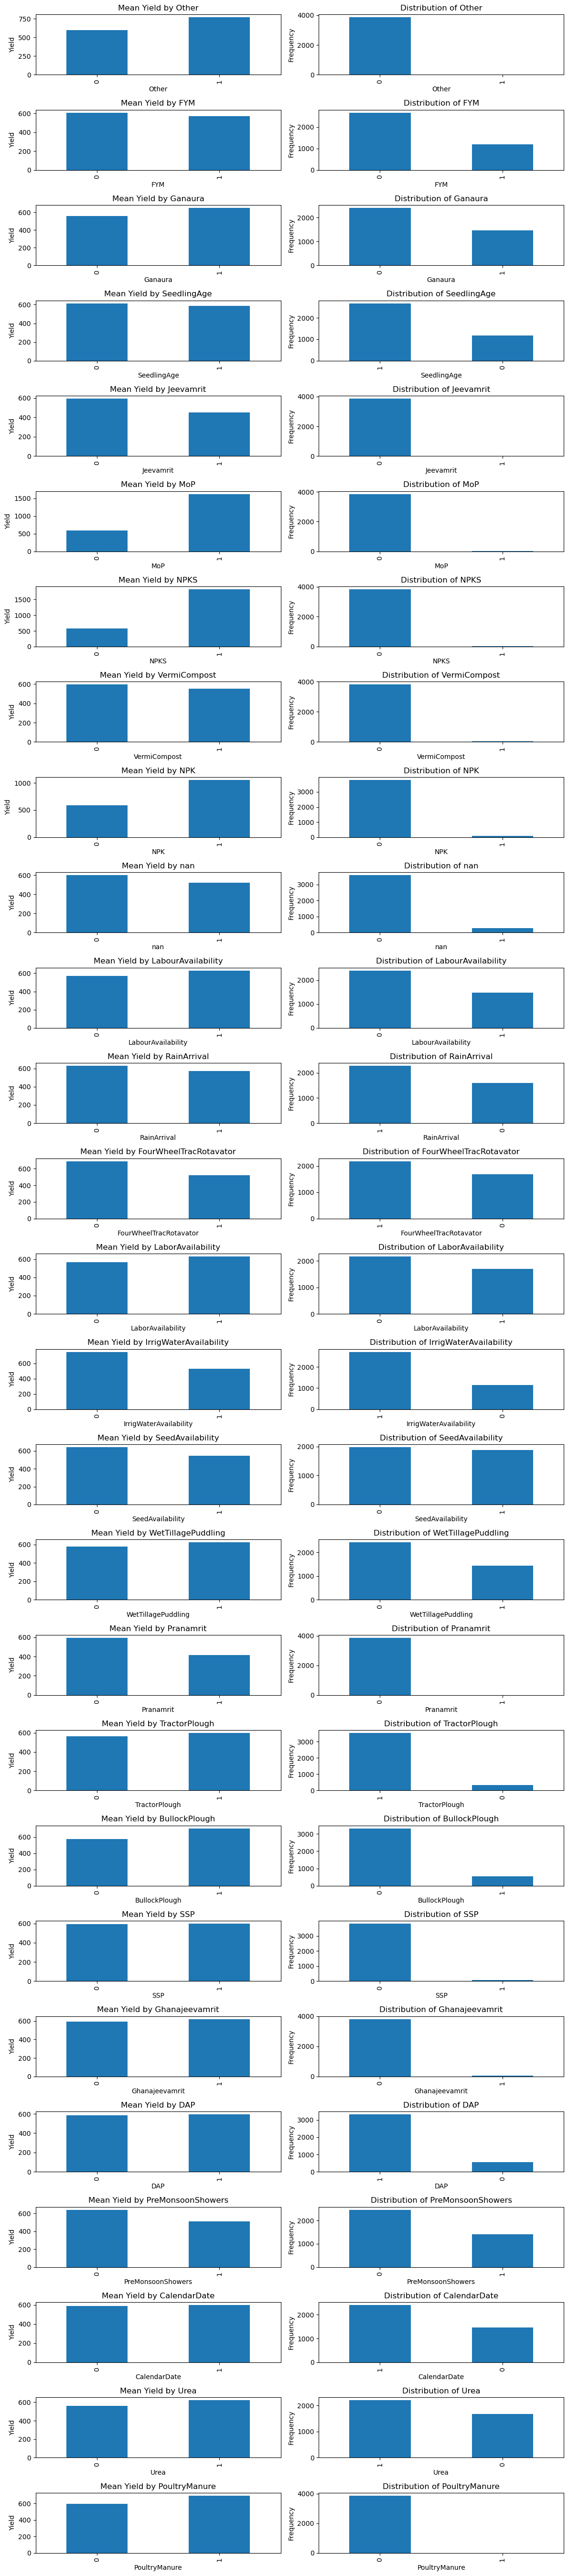

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have already defined df and unique_words

# Define the number of rows and columns for the subplots
num_rows = len(unique_words)
number_of_cols = 2  # Two columns: Mean Yield and Distribution

# Create subplots
fig, axes = plt.subplots(num_rows, number_of_cols, figsize=(12, 2*num_rows))

# Loop through each unique word column
for i, column in enumerate(unique_words):
    # Plot Mean Yield
    ax = axes[i, 0]
    df.groupby(column)['Yield'].mean().plot(kind='bar', ax=ax)
    ax.set_title(f'Mean Yield by {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Yield')

    # Plot Distribution
    ax = axes[i, 1]
    df[column].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Adjust layout and spacing
plt.tight_layout()

# Show the subplots
plt.show()


In [18]:
# Initialize an empty list to store column names
columns_with_large_difference = []

# Loop through each unique word column
for column in unique_words:
    # Calculate the mean yield for each category in the column
    mean_yield_by_category = df.groupby(column)['Yield'].mean()
    
    # Calculate the difference in mean yield between categories
    yield_differences = mean_yield_by_category.max() - mean_yield_by_category.min()
    
    # Check if the difference is at least 350
    if yield_differences >= 200:
        columns_with_large_difference.append(column)

# List of columns with a difference of at least 350 in mean yield
print(columns_with_large_difference)


['MoP', 'NPKS', 'NPK', 'IrrigWaterAvailability']


In [19]:
columns_with_more_than_1000_nulls

['Ganaura', 'CropOrgFYM', 'BasalUrea', '2tdUrea', '2appDaysUrea']

In [20]:
num_cols

['CultLand',
 'CropCultLand',
 'CropTillageDepth',
 'SeedlingsPerPit',
 'TransplantingIrrigationHours',
 'TransIrriCost',
 'StandingWater',
 'Ganaura',
 'CropOrgFYM',
 'NoFertilizerAppln',
 'BasalDAP',
 'BasalUrea',
 '1tdUrea',
 '1appDaysUrea',
 '2tdUrea',
 '2appDaysUrea',
 'Harv_hand_rent',
 'Residue_length',
 'Residue_perc',
 'Acre']

In [21]:
# Remove columns with more than 1000 null values from 'num_cols'
num_cols = [col for col in num_cols if col not in columns_with_more_than_1000_nulls]

#TODO : Conduct PCA, Mutual information analysis and categorical separation for feature selection.
#TODO : Do better Feature Engineering.


In [22]:
df['District'].unique()

array(['Nalanda', 'Gaya', 'Vaishali', 'Jamui'], dtype=object)

In [23]:
df

,ID,District,Block,CultLand,CropCultLand,LandPreparationMethod,CropTillageDate,CropTillageDepth,CropEstMethod,RcNursEstDate,...,CalendarDate,RainArrival,SeedlingAge,PreMonsoonShowers,SeedAvailability,LabourAvailability,WetTillagePuddling,TractorPlough,FourWheelTracRotavator,BullockPlough
0,ID_GTFAC7PEVWQ9,Nalanda,Noorsarai,45,40,TractorPlough FourWheelTracRotavator,July,5,Manual_PuddledRandom,June,...,1,1,1,0,1,0,0,1,1,0
1,ID_TK40ARLSPOKS,Nalanda,Rajgir,26,26,WetTillagePuddling TractorPlough FourWheelTrac...,July,5,Manual_PuddledRandom,June,...,1,1,1,1,1,1,1,1,1,0
2,ID_1FJY2CRIMLZZ,Gaya,Gurua,10,10,TractorPlough FourWheelTracRotavator,June,6,Manual_PuddledRandom,June,...,0,0,1,1,0,1,0,1,1,0
3,ID_I3IPXS4DB7NE,Gaya,Gurua,15,15,TractorPlough FourWheelTracRotavator,June,6,Manual_PuddledRandom,June,...,1,1,1,1,1,1,0,1,1,0
4,ID_4T8YQWXWHB4A,Nalanda,Noorsarai,60,60,TractorPlough WetTillagePuddling,July,4,Manual_PuddledRandom,June,...,1,1,1,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865,ID_7ZZQ6R4XB4FK,Nalanda,Rajgir,28,28,WetTillagePuddling TractorPlough FourWheelTrac...,July,6,LineSowingAfterTillage,June,...,0,0,0,0,0,0,1,1,1,0
3866,ID_PVVDF6LK6FO8,Vaishali,Mahua,5,5,WetTillagePuddling TractorPlough FourWheelTrac...,July,5,Manual_PuddledRandom,July,...,0,0,0,0,0,1,1,1,1,0
3867,ID_RBYVUPRATVMW,Nalanda,Noorsarai,50,45,TractorPlough,July,5,Manual_PuddledRandom,June,...,1,0,0,0,0,0,0,1,0,0
3868,ID_ARE9QWENJNJ2,Jamui,Khaira,20,20,TractorPlough,July,3,Manual_PuddledRandom,June,...,0,1,1,0,1,0,0,1,0,0


In [24]:
location = ['District']

In [36]:
features = num_cols + filtered_cat_cols + dates 

In [26]:
df[filtered_cat_cols]

,District,CropEstMethod,TransplantingIrrigationPowerSource,PCropSolidOrgFertAppMethod,MineralFertAppMethod,MineralFertAppMethod.1,Harv_method,Threshing_method,Stubble_use
0,Nalanda,Manual_PuddledRandom,Electric,NaN,Broadcasting,Broadcasting,machine,machine,plowed_in_soil
1,Nalanda,Manual_PuddledRandom,Electric,NaN,Broadcasting,Broadcasting,hand,machine,plowed_in_soil
2,Gaya,Manual_PuddledRandom,Electric,SoilApplied,SoilApplied,RootApplication,hand,machine,plowed_in_soil
3,Gaya,Manual_PuddledRandom,NaN,SoilApplied,Broadcasting,Broadcasting,hand,hand,plowed_in_soil
4,Nalanda,Manual_PuddledRandom,Electric,NaN,Broadcasting,Broadcasting,machine,machine,plowed_in_soil
...,...,...,...,...,...,...,...,...,...
3865,Nalanda,LineSowingAfterTillage,Electric,SoilApplied,Broadcasting,Broadcasting,machine,machine,plowed_in_soil
3866,Vaishali,Manual_PuddledRandom,Diesel,NaN,RootApplication,Broadcasting,hand,hand,plowed_in_soil
3867,Nalanda,Manual_PuddledRandom,Electric,Broadcasting,Broadcasting,NaN,hand,hand,plowed_in_soil
3868,Jamui,Manual_PuddledRandom,NaN,NaN,Broadcasting,NaN,hand,hand,plowed_in_soil


## Preprocessing

In [27]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression

from sklearn.decomposition import PCA

# Load your dataset into a DataFrame df

# Define the columns for PCA
pca_columns = num_cols


# Create transformers for PCA columns
pca_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10))  # You can adjust the number of components
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Custom transformer using onehot_seperator
from sklearn.base import BaseEstimator, TransformerMixin


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
    #('encoder', OneHotEncoder(handle_unknown='ignore'))])

onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

# Create a column transformer that applies the transformers to the respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('dat', categorical_transformer, dates),
        ('dist', onehot_transformer, location),
        ('cat', categorical_transformer, filtered_cat_cols)
    ])

# Create the full data preprocessing pipeline
data_preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and transform the data
X = df[features]
y = df[label]
X_preprocessed = data_preprocessing_pipeline.fit_transform(X)

test_filtered = test[features]
test_preprocessed = data_preprocessing_pipeline.fit_transform(test_filtered)

# Scale the target variable y
y_scaler = RobustScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Now you have X_train, X_test, y_train, and y_test for further processing with selected features

# Display a sample of the preprocessed data
print(X_train)


[[-0.60846419 -0.7047623   0.4516101  ...  0.          0.
   1.        ]
 [-0.28006002 -0.1688793  -1.31377483 ...  0.          1.
   1.        ]
 [-0.73982585 -0.66903677  0.4516101  ...  0.          0.
   1.        ]
 ...
 [-0.28006002 -0.1688793   1.33430256 ...  0.          1.
   1.        ]
 [-0.11585794 -0.1688793  -0.43108237 ...  0.          1.
   1.        ]
 [-0.11585794 -0.2760559  -1.31377483 ...  0.          1.
   1.        ]]


## Model Selection

In [31]:
df[features]

,CultLand,CropCultLand,CropTillageDepth,SeedlingsPerPit,TransplantingIrrigationHours,TransIrriCost,StandingWater,NoFertilizerAppln,BasalDAP,1tdUrea,...,Stubble_use,CropTillageDate,RcNursEstDate,SeedingSowingTransplanting,Harv_date,Threshing_date,MoP,NPKS,NPK,IrrigWaterAvailability
0,45,40,5,2.0,5.0,200.0,2.0,2,NaN,15.0,...,plowed_in_soil,July,June,July,November,November,0,0,0,1
1,26,26,5,2.0,5.0,125.0,3.0,2,15.0,20.0,...,plowed_in_soil,July,June,July,November,December,0,0,0,1
2,10,10,6,2.0,4.0,80.0,2.0,2,4.0,5.0,...,plowed_in_soil,June,June,August,December,January,0,0,0,1
3,15,15,6,2.0,NaN,NaN,NaN,2,6.0,5.0,...,plowed_in_soil,June,June,July,December,December,0,0,0,1
4,60,60,4,2.0,9.0,300.0,2.0,2,15.0,30.0,...,plowed_in_soil,July,June,July,November,December,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865,28,28,6,NaN,7.0,360.0,5.0,2,18.0,12.0,...,plowed_in_soil,July,June,July,November,December,0,0,0,0
3866,5,5,5,1.0,3.0,NaN,3.0,3,6.0,6.0,...,plowed_in_soil,July,July,July,October,November,0,0,0,1
3867,50,45,5,1.0,6.0,120.0,5.0,1,NaN,NaN,...,plowed_in_soil,July,June,July,October,October,0,0,0,1
3868,20,20,3,4.0,2.0,NaN,9.0,1,7.0,NaN,...,plowed_in_soil,July,June,July,November,December,0,0,0,1


In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize the models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Elastic Net': ElasticNet(),
    'LightGBM': LGBMRegressor(),
}

# Create a dictionary to store RMSE values
rmse_results = {}

# Define the number of folds for cross-validation
num_folds = 5

# Iterate through the models and calculate RMSE using cross-validation
for model_name, model in models.items():
    # Calculate RMSE using cross-validation
    rmse_scores = np.sqrt(-cross_val_score(model, X_train, y_train, cv=num_folds, scoring="neg_mean_squared_error"))
    
    # Calculate the average RMSE across folds
    avg_rmse = np.mean(rmse_scores)
    
    # Store the average RMSE in the dictionary
    rmse_results[model_name] = avg_rmse

# Now the rmse_results dictionary contains the average RMSE for each model based on 5-fold cross-validation


In [29]:
# Print the RMSE for each model
model_scores = pd.DataFrame() 
for model_name, rmse in rmse_results.items():
    model_scores = model_scores.append({'Model': model_name, 'RMSE': rmse}, ignore_index=True)


C:\Users\User\AppData\Local\Temp\ipykernel_2340\3930545847.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_scores = model_scores.append({'Model': model_name, 'RMSE': rmse}, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_2340\3930545847.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_scores = model_scores.append({'Model': model_name, 'RMSE': rmse}, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_2340\3930545847.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_scores = model_scores.append({'Model': model_name, 'RMSE': rmse}, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_2340\3930545847.py:4: FutureWarning: The frame.append method is deprecated and will 

In [30]:
model_scores_sorted = model_scores.sort_values(by='RMSE', ascending=True)
model_scores_sorted

,Model,RMSE
5,LightGBM,345.395838
4,Elastic Net,362.632647
3,Gradient Boosting,370.831321
0,Linear Regression,380.052327
2,K-Nearest Neighbors,392.725462
1,Random Forest,397.199023


Model	RMSE
*	LightGBM	3.456324e+02
*	Elastic Net	3.661917e+02
*	Gradient Boosting	3.666799e+02
*	K-Nearest Neighbors	3.920599e+02
*	Random Forest	3.953444e+02
*	Linear Regression	9.988082e+10


Model	RMSE
*	LightGBM	345.716788
*	Elastic Net	362.918700
*	Gradient Boosting	363.571103
*	Linear Regression	377.800088
*	Random Forest	389.838516
*	K-Nearest Neighbors	390.417634

Model	RMSE
*	LightGBM	345.395838
*	Elastic Net	362.632647
*	Gradient Boosting	370.831321
*	Linear Regression	380.052327
*	K-Nearest Neighbors	392.725462
*	Random Forest	397.199023

In [32]:
lgbm_model = LGBMRegressor(random_state=1).fit(X_train, y_train)  # Convert one-hot encoded y_train to 1D array
lgbm_predictions = lgbm_model.predict(test_preprocessed)

In [33]:
test['Yield'] = lgbm_predictions



In [34]:
sub_cols = ['ID', 'Yield']
Submission = test[sub_cols]

In [35]:
Submission.to_csv('Submission.csv', index= False)